In [1]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
import re
from ast import literal_eval
import json
import string
import os

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

from IPython.display import display, Latex, Markdown

In [2]:
#print(''.join(open("vader_lexicon.txt").readlines()[:10]))

In [3]:
sent = pd.read_csv(filepath_or_buffer='vader_lexicon.txt',
                  sep='\t',
                  usecols=[0,1],
                  header = None,
                  names=['token','polarity'],
                  index_col='token')

In [4]:
# HELPER FUNCTION THAT CREATES DICTIONARY
def create_dictionary():
    file_path = '/Users/anoglows/Documents/movieProject/scripts/'
    scripts = dict()

    files = os.listdir(file_path)
    for name in files:
        if len(re.findall(r'.txt', name)) > 0:
            movie_name = name[0:len(name)-4]
            scripts[movie_name] = file_path + name
    return scripts

In [5]:
# HELPER FUNCTION TO REMOVE PUNCTION AND MAKE LOWER CASE
def get_clean_quote(quote):
    punct_re = r'[^\s\w]'
    clean_quote = quote.lower()
    clean_quote = re.sub(punct_re, " ", clean_quote)
    return clean_quote

In [6]:
# HELPER FUNCTIOON TO REMOVE STAGE DIRECTIONS
def get_no_stage_quote(quote):
    punct_re1 = r'\(.+\)'
    punct_re2 = r'\[.+\]'
    clean_quote = quote.lower()
    clean_quote = re.sub(punct_re1, ' ', clean_quote)
    clean_quote = re.sub(punct_re2, ' ', clean_quote)
    return clean_quote

In [7]:
# HELPER FUNCTION TO GETE EACH LINE
def find_lines(script_txt, movie_title):
    df = pd.DataFrame(columns=[0, 1, 2, 3, 4, 5])
    script = open(script_txt,'r')
    lines = script.read().split('\n')
    index = 0
    for line in lines:  
        if len(re.findall(r"^[^:]+:", line)) > 0:
            begin_index = len(re.findall(r"^[^:]+:", line)[0])+1
            character = re.findall(r"^[^:]+:", line)[0][0:begin_index - 2]
            quote = line[begin_index:len(line)]
            clean_quote = get_clean_quote(quote)
            no_stage_quote = get_clean_quote(get_no_stage_quote(quote))
            entry = pd.Series([movie_title, index, character, quote, clean_quote, no_stage_quote])
            df = df.append(entry, ignore_index=True)
            index += 1
    df = df.rename(index= str, columns= {0:'movie_title', 1:'index', 2:'character', 3:'quote', 4:'clean_quote', 5:'no_stage_quote'})
    return df

In [8]:
# HELPER FUNCTION FOR SCRIPT_TO_POLARITY TO TRANSFORM DATAFRAME TO GET POLARITY
def get_tidy_format(df, col):
    temp = (df[col]
        .str.split(expand=True)
        .stack()
        .reset_index(level=1)
        .rename(columns={0:'word','level_1':'num'})
    )
    return temp

In [9]:
# HELPER FUNCTION TO GET POLARITY OF A SCRIPT
def get_polarity(source_df, dest_df):
    dest_df['polarity'] = (
        source_df.merge(sent, how='left', left_on='word', right_index=True)
        .reset_index().loc[:, ['index', 'polarity']]
        .groupby('index').sum().fillna(0)
    )
    return dest_df

In [10]:
# FUNCTION TO TRANSFORM A SCRIPT INTO DATAFRAME
def script_to_polarity(script_txt, movie_title, col='clean_quote'):
    
    df = find_lines(script_txt, movie_title)
    tidy_df = get_tidy_format(df, col)
    polar_df = get_polarity(tidy_df, df)
    nonzero_polar_df = polar_df[polar_df['polarity'] != 0.0]
    return polar_df, nonzero_polar_df

In [11]:
# FUNCTION TO GET MOST NEGATIVE QUOTES FROM A MOVIE
def get_most_negative_quotes(df, min_lines=0, num=5):
    df = df.groupby('character').filter(lambda x: x['polarity'].count() >= min_lines)
    return df.sort_values('polarity').head(num)

In [12]:
# FUNCTION TO GET MOST POSITIVE QUOTES FROM A MOVIE
def get_most_positive_quotes(df, min_lines=0, num=5):
    df = df.groupby('character').filter(lambda x: x['polarity'].count() >= min_lines)
    return df.sort_values('polarity', ascending=False).head(num)

In [13]:
# FUNCTION TO GET A CHARACTERS LINES
def get_character_lines(df, character, sortby='index'):
    return df[df['character'].str.lower() == character.lower()].sort_values(sortby)

In [14]:
# FUNCTION THTAGETS AVERAGE POLARITY FOR CHARACTERS IN A MOVIE
def get_character_avg_polarity_list(df, num_characters=5):
    return df.groupby(['movie_title', 'character']).agg({'index':'count','polarity':'mean'}).sort_values('index', ascending=False).head(num_characters).sort_values('polarity').rename(index=str, columns={'index':'line_count'})    

In [15]:
# FUNCTION THAT GETS THE AVERAGE POLARITY OF EACH LINE IN A MOVIE
def get_movie_line_avg_polarity(df, col):
    df = df.dropna()
    return df.groupby('movie_title')['polarity'].mean(), df['polarity'].sum() / len(df[df['polarity'] != 0.0])

In [16]:
def scatter_polar_top_5(df):
    characters = list(df.groupby('character').agg({'index':'count'}).sort_values('index', ascending=False).head(5).index)#.sort_values('polarity').rename(index=str, columns={'index':'line_count'})    
    top_5_df = df[df['character'].isin(characters)].reset_index(drop=True).reset_index()
    #print(top_5_df)
    ax = sns.scatterplot(data= top_5_df, x= 'level_0', y= 'polarity', hue='character', palette='bright')
    ax.axhline(y=0, color='black')
    avg = get_character_avg_polarity_list(df)
    
    
    g = sns.FacetGrid(top_5_df, col="character", height=4, aspect=.5)
    g.map(plt.scatter, x='level_0', y="polarity")
    display(top_5_df.head())

In [17]:
scripts = create_dictionary()

In [18]:
dfs = dict()
nonzero_dfs = dict()
for key in scripts:
    dfs[key], nonzero_dfs[key] = script_to_polarity(scripts[key] , key)

In [19]:
#ts3_df, nonzero_ts3_df = script_to_polarity(scripts['toy_story_3'])
#avengers_df, nonzero_avengers_df = script_to_polarity(scripts['avengers_3'], 'no_stage_quote')
#insideout_df, nonzero_insideout_df = script_to_polarity(scripts['inside_out'], 'no_stage_quote')

In [20]:
get_most_negative_quotes(dfs['ant_man'], num=5)

,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
94,ant_man,94,Scott Lang,"Well, technically, I didn’t rob them. Robbery ...",well technically i didn t rob them robbery ...,well technically i didn t rob them robbery ...,-9.7
80,ant_man,80,Dale,"No, it wasn’t a violent crime. It was a cool c...",no it wasn t a violent crime it was a cool c...,no it wasn t a violent crime it was a cool c...,-7.9
392,ant_man,392,Dr. Hank Pym,This isn’t the first time these guys have trie...,this isn t the first time these guys have trie...,this isn t the first time these guys have trie...,-7.8
856,ant_man,856,Luis,"Yeah, and this dude sounds like a bad-ass, man...",yeah and this dude sounds like a bad ass man...,yeah and this dude sounds like a bad ass man...,-7.4
573,ant_man,573,Dr. Hank Pym,"No, no. No, no, no. Not those three wombats. N...",no no no no no not those three wombats n...,no no no no no not those three wombats n...,-7.2


In [21]:
all_df = dfs[list(dfs.keys())[0]]
for key in list(dfs.keys())[1:]:
    all_df = all_df.append(dfs[key])

In [22]:
all_nonzero_df = nonzero_dfs[list(dfs.keys())[0]]
for key in list(nonzero_dfs.keys())[1:]:
    all_nonzero_df = all_nonzero_df.append(nonzero_dfs[key])

In [23]:
df_agg = all_nonzero_df.groupby(['movie_title', 'character']).agg({'index':'count', 'polarity':'mean'})
g = df_agg[['index', 'polarity']].groupby(level=0, group_keys=False)
res = g.apply(lambda x: x.sort_values('index', ascending=False).head(10))

In [24]:
g2 = res[['index', 'polarity']].groupby(level=0, group_keys=False)
most_positive = g2.apply(lambda x: x.sort_values('polarity', ascending=False).head(1))
most_negative = g2.apply(lambda x: x.sort_values('polarity', ascending=True).head(1))
overall_sentiment = all_nonzero_df.groupby('movie_title').agg({'polarity':'mean'})

In [25]:
pd.set_option('display.max_colwidth', -1)

In [26]:
#overall_sentiment.sort_values('polarity')
clean_neg = most_negative.drop('index', axis=1).reset_index().rename(index=str, columns={'polarity':'neg_rating', 'character':'most_negative_character'})
clean_pos = most_positive.drop('index', axis=1).reset_index().rename(index=str, columns={'polarity':'pos_rating', 'character':'most_positive_character'})
clean_overall = overall_sentiment.reset_index().rename(index=str, columns={'polarity':'avg_polarity'})

In [27]:
combined_pol = clean_neg.merge(clean_pos, on='movie_title').merge(clean_overall)

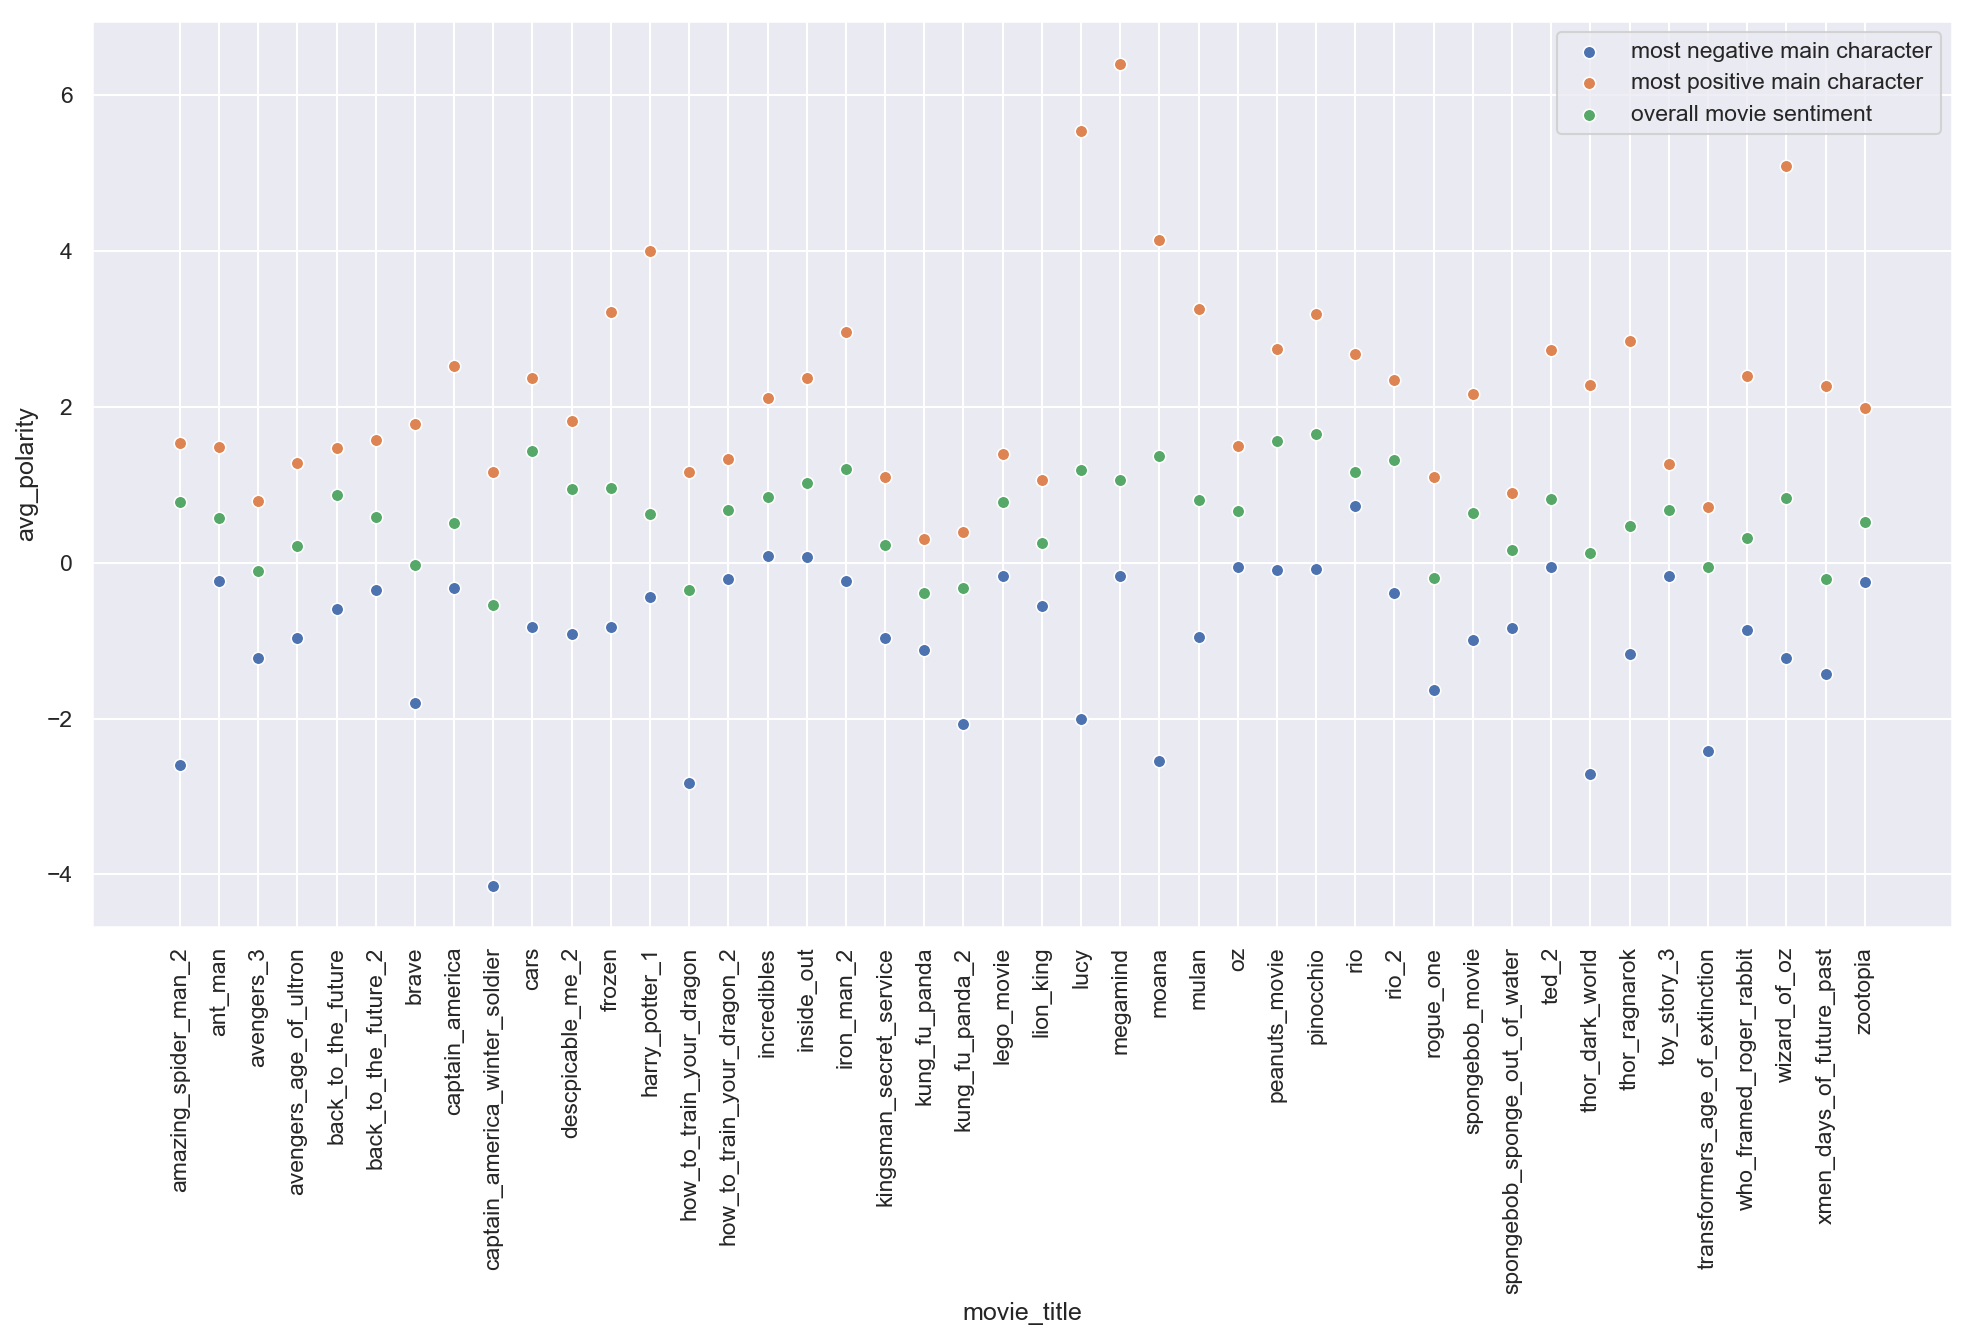

In [36]:
ax = sns.scatterplot(data=combined_pol, x = 'movie_title', y = 'neg_rating', label= 'most negative main character')
ax = sns.scatterplot(data=combined_pol, x = 'movie_title', y = 'pos_rating', label= 'most positive main character')
ax = sns.scatterplot(data=combined_pol, x = 'movie_title', y = 'avg_polarity', label= 'overall movie sentiment')
#for tick in ax.get_xticklabels():
[tick.set_rotation(90) for tick in ax.get_xticklabels()];
#[ax.text(p[0], p[1]+50, p[1], color='g') for p in zip(ax.get_xticks(), num_records_yob)]


In [30]:
tony = all_df[all_df['character'] == 'Tony Stark'].groupby('movie_title').count()['index'].to_frame().rename(index=str, columns={'index':'line_count'})
tony['mean'] = list(all_df[all_df['character'] == 'Tony Stark'].groupby('movie_title').mean()['polarity'])
tony['zero_count'] = list(all_df[(all_df['character'] == 'Tony Stark') & (all_df['polarity'] == 0.0)].groupby('movie_title').count()['quote'])
tony['negative_count'] = list(all_df[(all_df['character'] == 'Tony Stark') & (all_df['polarity'] < 0.0)].groupby('movie_title').count()['clean_quote'])
tony['positive_count'] = list(all_df[(all_df['character'] == 'Tony Stark') & (all_df['polarity'] > 0.0)].groupby('movie_title').count()['no_stage_quote'])
tony['zero_percent'] = tony['zero_count'] / tony['line_count']
tony['negative_percent'] = tony['negative_count'] / tony['line_count']
tony['positive_percent'] = tony['positive_count'] / tony['line_count']

tony

#list(all_df[all_df['character'] == 'Tony Stark'].groupby('movie_title').mean()['polarity'])


,line_count,mean,zero_count,negative_count,positive_count,zero_percent,negative_percent,positive_percent
movie_title,,,,,,,,
avengers_3,127,0.451181,46,32,49,0.362205,0.251969,0.385827
avengers_age_of_ultron,179,0.248045,77,35,67,0.430168,0.195531,0.374302


From the above analysis we can see that Tony Stark has more lines in Avengers Age of Ultron compared to Avengers 3.

From this we can tell that he has a higher polarity in avengers 3.

We can see that age of ultron, tony has more lines that do not contribute positively or negatively

In [31]:
def character_comp(c):
    df = all_df[all_df['character'] == c].groupby('movie_title').count()['index'].to_frame().rename(index=str, columns={'index':'line_count'})
    df['character'] = c
    df['mean'] = list(all_df[all_df['character'] == c].groupby('movie_title').mean()['polarity'])
    df['zero_count'] = list(all_df[(all_df['character'] == c) & (all_df['polarity'] == 0.0)].groupby('movie_title').count()['quote'])
    df['negative_count'] = list(all_df[(all_df['character'] == c) & (all_df['polarity'] < 0.0)].groupby('movie_title').count()['clean_quote'])
    df['positive_count'] = list(all_df[(all_df['character'] == c) & (all_df['polarity'] > 0.0)].groupby('movie_title').count()['no_stage_quote'])
    df['zero_percent'] = df['zero_count'] / df['line_count']
    df['negative_percent'] = df['negative_count'] / df['line_count']
    df['positive_percent'] = df['positive_count'] / df['line_count']
    return df


In [32]:
all_characters = all_df['character'].unique()
plus_two_characters = []
for c in all_characters:
    temp = all_df[all_df['character'] == c].groupby('movie_title').count()
    if len(temp) >= 2 and len([c for c in temp['index'] if c > 10]) == len(temp['index']):
        plus_two_characters += [c]


In [33]:
print(plus_two_characters)

['Peter Parker', 'Thor', 'Bruce Banner', 'Tony Stark', 'Vision', 'Wanda Maximoff', 'Natasha Romanoff', 'James Rhodes', 'Marty', 'Doc', 'Jennifer', 'Biff', 'Lorraine', 'Dr. Arnim Zola', 'Lucy', 'Eduardo', 'Stoick', 'Gobber', 'Astrid', 'Hiccup', 'Tuffnut', 'Snotlout', 'Ruffnut', 'Fishlegs', 'Charlie', 'TIGRESS', 'PO', 'MR. PING', 'SHIFU', 'MANTIS', 'CRANE', 'VIPER', 'Benny', 'Richard', 'Glinda', 'Blu', 'Tulio', 'Nico', 'Pedro', 'Nigel', 'Jewel', 'Rafael', 'Luiz', 'Mr. Krabs', 'SpongeBob', 'Squidward', 'Patrick', 'Plankton', 'Odin']


In [34]:
cc = dict()
cc[plus_two_characters[0]] = character_comp(plus_two_characters[0])
all_comp = character_comp(plus_two_characters[0]).reset_index()
for c in plus_two_characters[1:]:
    cc[c] = character_comp(c)
    all_comp = all_comp.append(cc[c].reset_index())
all_comp = all_comp.reset_index()

In [42]:
all_comp[(all_comp['movie_title'] == 'kung_fu_panda') | (all_comp['movie_title'] == 'kung_fu_panda_2')]

,index,movie_title,line_count,character,mean,zero_count,negative_count,positive_count,zero_percent,negative_percent,positive_percent
54,0,kung_fu_panda,28,TIGRESS,-0.185714,14,8,6,0.500000,0.285714,0.214286
55,1,kung_fu_panda_2,69,TIGRESS,-0.747826,28,30,11,0.405797,0.434783,0.159420
56,0,kung_fu_panda,229,PO,-0.194760,85,70,74,0.371179,0.305677,0.323144
57,1,kung_fu_panda_2,202,PO,0.218317,88,46,68,0.435644,0.227723,0.336634
58,0,kung_fu_panda,37,MR. PING,-0.943243,6,23,8,0.162162,0.621622,0.216216
59,1,kung_fu_panda_2,48,MR. PING,-0.187500,16,17,15,0.333333,0.354167,0.312500
60,0,kung_fu_panda,163,SHIFU,-0.189571,58,62,43,0.355828,0.380368,0.263804
61,1,kung_fu_panda_2,14,SHIFU,-1.778571,2,5,7,0.142857,0.357143,0.500000
62,0,kung_fu_panda,18,MANTIS,-0.022222,7,5,6,0.388889,0.277778,0.333333
63,1,kung_fu_panda_2,22,MANTIS,-0.404545,9,8,5,0.409091,0.363636,0.227273


In [45]:
dfs['inside_out']

,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
0,inside_out,0,Joy,"[voice-over] ""Do you ever look at someone and wonder, what is going on inside their head? Well, I know. Well, I know Riley’s head.""",voice over do you ever look at someone and wonder what is going on inside their head well i know well i know riley s head,do you ever look at someone and wonder what is going on inside their head well i know well i know riley s head,2.2
1,inside_out,1,Joy,"[voice-over] ""And there she was."" [Joy watches Riley’s parents through Riley’s eyes]",voice over and there she was joy watches riley s parents through riley s eyes,,2.8
2,inside_out,2,Mom,"""Hello. Riley.""",hello riley,hello riley,0.0
3,inside_out,3,Dad,"""Oh, look at you. Aren’t you a little bundle of joy.""",oh look at you aren t you a little bundle of joy,oh look at you aren t you a little bundle of joy,2.8
4,inside_out,4,Joy,"""Whoa.""",whoa,whoa,0.0
5,inside_out,5,Joy,"[voice-over] ""It was amazing. Just Riley and me forever.""",voice over it was amazing just riley and me forever,it was amazing just riley and me forever,2.8
6,inside_out,6,Joy,"[voice-over] ""Or for thirty-three seconds.""",voice over or for thirty three seconds,or for thirty three seconds,0.0
7,inside_out,7,Sadness,"""I’m Sadness.""",i m sadness,i m sadness,-1.9
8,inside_out,8,Joy,"""Oh, hello. I’m Joy, so. Can I just, if you could…I just want to fix that.""",oh hello i m joy so can i just if you could i just want to fix that,oh hello i m joy so can i just if you could i just want to fix that,3.1
9,inside_out,9,Joy,"""Thanks.""",thanks,thanks,1.9


In [133]:
import collections, re, operator
for key in dfs:
    bagsofwords = [collections.Counter(re.findall(r'\w+', line)) for line in dfs[key]['no_stage_quote']]
    dfs[key]['bags'] = bagsofwords

In [134]:
# FUNCTION THAT RETURNS CHARACTERS FROM MOVIE WITH MOST LINES
def get_characters_with_most_lines(movie, num = 5):
    return dfs[movie].groupby('character').count().sort_values('index',ascending=False).index[0:num]

In [161]:
list(dfs.keys())
word_counts = {}
for movie in dfs:
    t = pd.DataFrame()

    for character in get_characters_with_most_lines(movie, 5):
        temp = pd.Series(sum(dfs[movie][dfs[movie]['character'] == character]['bags'], collections.Counter()).most_common())
        t[character] = temp
    word_counts[movie] = t


In [151]:
sum([i[1] for i in word_counts['avengers_3']['Tony Stark']])

1361

In [160]:
list(word_counts['avengers_3']['Tony Stark'][0]) + [3]

['you', 70, 3]

In [163]:
word_counts['cars'].head()

,Lightning McQueen,Sally Carrera,Tow Mater,Doc Hudson,Luigi
0,"(i, 145)","(you, 56)","(you, 50)","(you, 43)","(you, 22)"
1,"(you, 121)","(i, 30)","(i, 48)","(i, 33)","(a, 17)"
2,"(no, 64)","(it, 29)","(s, 24)","(a, 18)","(i, 11)"
3,"(a, 52)","(to, 25)","(the, 19)","(it, 18)","(tires, 10)"
4,"(the, 52)","(the, 24)","(to, 17)","(t, 16)","(no, 9)"


From this dataframe we can see that lightning mcqueen is a douche bag. He says I the most while every other character says you the most. 

Lightning mcqueen:
    - i:1
    - you:2
    - me:8
    - my:27
    - we:31
Sally:
    - i:2
    - you:2
    - we:19
    - me:31
    - our:44
Mater:
    - you:1
    - i:2
    - my:24
    - me:41
    - your:50
Doc:
    - you:1
    - i:2
    - me:16
    - my:22
    - we:38
Luigi:
    - you:1
    - i:3
    - my:6

In [178]:
word_counts['cars'].head(50)

,Lightning McQueen,Sally Carrera,Tow Mater,Doc Hudson,Luigi
0,"(i, 145)","(you, 56)","(you, 50)","(you, 43)","(you, 22)"
1,"(you, 121)","(i, 30)","(i, 48)","(i, 33)","(a, 17)"
2,"(no, 64)","(it, 29)","(s, 24)","(a, 18)","(i, 11)"
3,"(a, 52)","(to, 25)","(the, 19)","(it, 18)","(tires, 10)"
4,"(the, 52)","(the, 24)","(to, 17)","(t, 16)","(no, 9)"
5,"(s, 49)","(a, 18)","(in, 14)","(the, 15)","(my, 8)"
6,"(to, 44)","(s, 15)","(t, 13)","(to, 15)","(the, 8)"
7,"(me, 40)","(t, 14)","(what, 12)","(that, 13)","(guido, 8)"
8,"(what, 39)","(and, 14)","(of, 12)","(and, 10)","(of, 8)"
9,"(m, 38)","(what, 14)","(a, 12)","(s, 8)","(it, 8)"


In [190]:
#dfs.keys()
for i in dfs:
    display(word_counts[i].head())

,Peter Parker,Gwen Stacy,Harry Osborn,Max Dillon,Aunt May
0,"(i, 214)","(i, 76)","(you, 80)","(i, 47)","(i, 58)"
1,"(you, 138)","(you, 61)","(i, 68)","(you, 45)","(you, 39)"
2,"(it, 61)","(it, 47)","(to, 32)","(me, 34)","(the, 28)"
3,"(to, 60)","(to, 39)","(it, 26)","(s, 23)","(it, 22)"
4,"(s, 59)","(that, 36)","(me, 22)","(it, 23)","(and, 22)"


,Scott Lang,Dr. Hank Pym,Hope van Dyne,Luis,Darren Cross
0,"(i, 125)","(you, 94)","(you, 62)","(i, 46)","(you, 54)"
1,"(you, 84)","(i, 78)","(to, 33)","(you, 42)","(i, 39)"
2,"(s, 71)","(the, 76)","(i, 32)","(s, 40)","(the, 39)"
3,"(the, 53)","(to, 66)","(the, 28)","(it, 32)","(to, 27)"
4,"(it, 53)","(s, 45)","(s, 28)","(the, 31)","(s, 18)"


,Tony Stark,Peter Quill,Thor,Thanos,Doctor Strange
0,"(you, 70)","(i, 41)","(the, 35)","(you, 40)","(the, 25)"
1,"(i, 53)","(you, 31)","(you, 27)","(i, 33)","(you, 19)"
2,"(s, 44)","(it, 23)","(i, 25)","(the, 22)","(i, 16)"
3,"(it, 32)","(s, 22)","(it, 20)","(it, 20)","(to, 15)"
4,"(a, 28)","(the, 21)","(s, 18)","(to, 18)","(of, 9)"


,Tony Stark,Steve Rogers,Bruce Banner,Ultron,Natasha Romanoff
0,"(the, 85)","(you, 48)","(you, 28)","(you, 53)","(you, 37)"
1,"(i, 73)","(the, 39)","(i, 27)","(the, 45)","(i, 31)"
2,"(s, 60)","(i, 34)","(the, 25)","(i, 42)","(the, 23)"
3,"(it, 60)","(s, 33)","(to, 19)","(to, 31)","(s, 21)"
4,"(a, 56)","(to, 25)","(s, 19)","(this, 18)","(a, 17)"


,Marty,Doc,George,Loraine,Biff
0,"(you, 124)","(i, 54)","(i, 51)","(you, 24)","(you, 35)"
1,"(i, 94)","(you, 53)","(you, 30)","(i, 22)","(i, 21)"
2,"(a, 58)","(the, 48)","(to, 19)","(marty, 13)","(mcfly, 17)"
3,"(doc, 55)","(s, 40)","(biff, 15)","(s, 10)","(it, 16)"
4,"(the, 54)","(a, 28)","(t, 15)","(a, 10)","(s, 12)"


,Marty,Doc,Biff,Lorraine,Jennifer
0,"(i, 91)","(the, 100)","(you, 46)","(you, 21)","(you, 7)"
1,"(doc, 77)","(to, 50)","(i, 39)","(i, 17)","(i, 6)"
2,"(s, 75)","(i, 48)","(the, 27)","(he, 14)","(we, 5)"
3,"(the, 60)","(you, 41)","(a, 23)","(t, 13)","(a, 4)"
4,"(you, 53)","(in, 41)","(s, 23)","(it, 13)","(marty, 4)"


,Merida,Elinor,Fergus,The Witch,Lord Dingwall
0,"(you, 46)","(you, 40)","(you, 18)","(you, 17)","(i, 3)"
1,"(i, 35)","(the, 36)","(the, 10)","(the, 12)","(my, 2)"
2,"(s, 25)","(i, 28)","(i, 10)","(i, 10)","(was, 2)"
3,"(the, 23)","(to, 21)","(s, 8)","(a, 8)","(he, 2)"
4,"(it, 18)","(merida, 13)","(merida, 7)","(that, 8)","(say, 2)"


,Steve Rogers,Peggy Carter,Col. Chester Phillips,James Barnes,Dr. Abraham Erskine
0,"(i, 102)","(you, 36)","(you, 51)","(you, 24)","(the, 25)"
1,"(you, 71)","(i, 22)","(s, 30)","(i, 13)","(you, 17)"
2,"(the, 51)","(the, 18)","(the, 28)","(the, 11)","(i, 15)"
3,"(a, 48)","(it, 15)","(i, 27)","(re, 9)","(a, 14)"
4,"(s, 39)","(a, 13)","(to, 26)","(t, 7)","(he, 13)"


,Steve Rogers,Natasha Romanoff,Nick Fury,Sam Wilson,Alexander Pierce
0,"(i, 87)","(you, 48)","(i, 30)","(you, 39)","(the, 47)"
1,"(you, 80)","(i, 46)","(to, 28)","(the, 28)","(you, 43)"
2,"(s, 54)","(the, 38)","(you, 26)","(i, 24)","(and, 32)"
3,"(it, 53)","(a, 32)","(a, 24)","(it, 22)","(a, 31)"
4,"(the, 52)","(it, 28)","(the, 21)","(a, 19)","(to, 31)"


,Lightning McQueen,Sally Carrera,Tow Mater,Doc Hudson,Luigi
0,"(i, 145)","(you, 56)","(you, 50)","(you, 43)","(you, 22)"
1,"(you, 121)","(i, 30)","(i, 48)","(i, 33)","(a, 17)"
2,"(no, 64)","(it, 29)","(s, 24)","(a, 18)","(i, 11)"
3,"(a, 52)","(to, 25)","(the, 19)","(it, 18)","(tires, 10)"
4,"(the, 52)","(the, 24)","(to, 17)","(t, 16)","(no, 9)"


,Gru,Lucy,Agnes,Margo,Eduardo
0,"(i, 46)","(you, 20)","(you, 11)","(you, 6)","(you, 9)"
1,"(you, 38)","(i, 18)","(s, 7)","(i, 6)","(i, 8)"
2,"(the, 33)","(gru, 12)","(he, 7)","(the, 4)","(the, 7)"
3,"(no, 24)","(it, 11)","(is, 5)","(so, 4)","(and, 5)"
4,"(s, 24)","(s, 10)","(i, 5)","(re, 4)","(is, 5)"


,Anna,Kristoff,Hans,Elsa,Olaf
0,"(i, 115)","(you, 51)","(you, 35)","(you, 35)","(i, 30)"
1,"(you, 82)","(i, 41)","(i, 31)","(t, 29)","(you, 23)"
2,"(it, 46)","(it, 28)","(to, 19)","(i, 27)","(and, 15)"
3,"(the, 40)","(s, 23)","(the, 17)","(no, 21)","(s, 14)"
4,"(no, 37)","(t, 23)","(anna, 12)","(don, 18)","(to, 14)"


,Harry,Ron,Hermione,Hagrid,(Scene
0,"(the, 77)","(the, 50)","(s, 41)","(you, 60)","(the, 116)"
1,"(i, 69)","(you, 42)","(you, 40)","(a, 44)","(a, 66)"
2,"(s, 61)","(s, 38)","(the, 38)","(to, 43)","(and, 55)"
3,"(to, 50)","(a, 36)","(it, 34)","(s, 43)","(is, 43)"
4,"(you, 49)","(and, 33)","(i, 25)","(harry, 39)","(in, 39)"


,Hiccup,Gobber,Stoick,Astrid,Hiccup (cont.)
0,"(i, 53)","(you, 40)","(you, 34)","(it, 13)","(i, 22)"
1,"(you, 46)","(the, 36)","(i, 30)","(you, 12)","(it, 18)"
2,"(to, 25)","(to, 18)","(the, 21)","(s, 10)","(you, 18)"
3,"(me, 20)","(it, 18)","(it, 15)","(i, 9)","(no, 15)"
4,"(a, 18)","(t, 16)","(he, 14)","(what, 9)","(s, 9)"


,Hiccup,Stoick,Astrid,Valka,Eret
0,"(you, 96)","(you, 29)","(you, 26)","(i, 37)","(you, 22)"
1,"(i, 69)","(the, 23)","(what, 16)","(you, 32)","(i, 15)"
2,"(the, 45)","(to, 18)","(to, 10)","(of, 19)","(to, 15)"
3,"(it, 45)","(a, 14)","(are, 9)","(to, 18)","(me, 12)"
4,"(to, 45)","(we, 14)","(t, 9)","(and, 17)","(drago, 10)"


,Helen (Mrs. Incredible),Bob,Mr. Incredible,Helen,E
0,"(you, 37)","(i, 28)","(i, 29)","(you, 33)","(you, 25)"
1,"(i, 33)","(to, 21)","(you, 17)","(the, 17)","(i, 15)"
2,"(to, 20)","(you, 18)","(it, 14)","(i, 15)","(is, 13)"
3,"(t, 18)","(the, 13)","(the, 13)","(to, 13)","(it, 9)"
4,"(a, 17)","(is, 10)","(to, 11)","(it, 11)","(the, 7)"


,Joy,Sadness,Fear,Disgust,Anger
0,"(you, 84)","(i, 52)","(no, 25)","(to, 20)","(it, 21)"
1,"(s, 78)","(it, 31)","(it, 22)","(it, 18)","(you, 20)"
2,"(i, 73)","(we, 29)","(s, 22)","(i, 18)","(s, 19)"
3,"(to, 73)","(the, 24)","(we, 18)","(we, 18)","(we, 18)"
4,"(we, 73)","(oh, 21)","(i, 18)","(s, 16)","(to, 16)"


,Tony,Pepper,Rhodey,Justin,Happy
0,"(i, 209)","(you, 77)","(i, 42)","(you, 119)","(i, 13)"
1,"(you, 193)","(i, 54)","(you, 30)","(i, 101)","(the, 9)"
2,"(it, 121)","(the, 40)","(it, 27)","(a, 57)","(what, 7)"
3,"(s, 100)","(to, 37)","(to, 24)","(the, 54)","(s, 6)"
4,"(the, 92)","(no, 25)","(the, 23)","(that, 53)","(got, 6)"


,Gary ‘Eggsy’ Unwin,Harry Hart,Merlin,Valentine,Arthur
0,"(you, 74)","(a, 78)","(you, 85)","(you, 71)","(to, 21)"
1,"(i, 69)","(i, 75)","(the, 57)","(the, 59)","(the, 15)"
2,"(s, 36)","(you, 71)","(to, 48)","(i, 55)","(a, 15)"
3,"(a, 36)","(the, 67)","(s, 42)","(to, 44)","(you, 15)"
4,"(the, 34)","(to, 49)","(it, 30)","(s, 32)","(it, 13)"


,PO,SHIFU,MR. PING,OOGWAY,TAI LUNG
0,"(i, 124)","(you, 97)","(you, 21)","(you, 19)","(you, 23)"
1,"(you, 59)","(i, 52)","(po, 13)","(to, 13)","(i, 14)"
2,"(the, 42)","(the, 50)","(i, 11)","(is, 13)","(the, 11)"
3,"(it, 39)","(to, 47)","(it, 11)","(it, 13)","(is, 8)"
4,"(to, 35)","(is, 35)","(the, 10)","(the, 11)","(me, 8)"


,PO,SHEN,TIGRESS,MR. PING,SOOTHSAYER
0,"(i, 97)","(you, 40)","(po, 18)","(you, 46)","(you, 29)"
1,"(you, 69)","(the, 29)","(the, 14)","(i, 29)","(i, 12)"
2,"(the, 38)","(i, 26)","(you, 11)","(a, 11)","(the, 11)"
3,"(to, 31)","(to, 20)","(to, 8)","(and, 10)","(is, 9)"
4,"(that, 29)","(that, 15)","(i, 7)","(me, 10)","(it, 8)"


,Emmet Brickowoski,Wyldstyle,Vitruvius,Lord Business,Bad Cop
0,"(i, 132)","(the, 65)","(the, 54)","(you, 47)","(the, 36)"
1,"(the, 85)","(you, 57)","(you, 36)","(the, 38)","(you, 20)"
2,"(you, 78)","(i, 38)","(to, 33)","(i, 33)","(to, 13)"
3,"(s, 54)","(s, 35)","(that, 23)","(that, 23)","(i, 13)"
4,"(what, 50)","(to, 35)","(a, 22)","(to, 20)","(is, 12)"


,Simba,Scar,Timon,Zazu,Nala
0,"(i, 89)","(you, 63)","(you, 39)","(the, 35)","(you, 28)"
1,"(you, 62)","(i, 50)","(s, 32)","(to, 26)","(s, 21)"
2,"(it, 47)","(the, 46)","(a, 24)","(a, 24)","(simba, 19)"
3,"(the, 37)","(simba, 33)","(the, 24)","(you, 22)","(the, 17)"
4,"(s, 36)","(it, 28)","(to, 23)","(i, 18)","(i, 16)"


,Lucy,Professor Norman,Pierre Del Rio,Richard,The Receptionist
0,"(i, 106)","(the, 43)","(you, 15)","(the, 24)","(i, 4)"
1,"(the, 69)","(to, 36)","(i, 9)","(i, 19)","(you, 4)"
2,"(you, 67)","(of, 35)","(to, 8)","(you, 18)","(here, 4)"
3,"(to, 61)","(you, 27)","(is, 7)","(it, 14)","(mr, 3)"
4,"(it, 45)","(i, 25)","(no, 7)","(s, 12)","(jang, 3)"


,Megamind,Roxanne Ritchie,Minion,Hal,Metro Man
0,"(i, 145)","(you, 68)","(you, 31)","(you, 44)","(i, 36)"
1,"(you, 113)","(i, 44)","(i, 31)","(i, 37)","(you, 21)"
2,"(the, 99)","(the, 33)","(sir, 25)","(s, 26)","(a, 14)"
3,"(s, 72)","(s, 32)","(it, 21)","(a, 25)","(s, 14)"
4,"(to, 67)","(it, 28)","(a, 17)","(the, 21)","(the, 13)"


,Moana,Maui,Tui,Gramma,Tamatoa
0,"(i, 116)","(you, 107)","(you, 28)","(the, 58)","(you, 34)"
1,"(the, 109)","(i, 81)","(the, 20)","(you, 37)","(i, 22)"
2,"(you, 90)","(the, 70)","(we, 15)","(to, 24)","(a, 19)"
3,"(it, 53)","(it, 67)","(and, 13)","(and, 22)","(it, 14)"
4,"(no, 40)","(s, 55)","(to, 13)","(i, 17)","(the, 14)"


,Mulan,Mushu,Shang,Chi Fu,Yao
0,"(i, 64)","(you, 63)","(the, 29)","(the, 21)","(you, 6)"
1,"(to, 23)","(i, 50)","(you, 28)","(a, 10)","(i, 5)"
2,"(you, 22)","(the, 36)","(i, 20)","(you, 9)","(and, 4)"
3,"(the, 21)","(s, 35)","(a, 19)","(your, 8)","(it, 3)"
4,"(t, 16)","(to, 33)","(of, 18)","(i, 8)","(ll, 3)"


,Oz,Glinda,Theodora,Evanora,China Girl
0,"(you, 177)","(you, 56)","(you, 53)","(you, 54)","(i, 23)"
1,"(i, 164)","(the, 43)","(i, 40)","(i, 38)","(you, 22)"
2,"(the, 92)","(i, 33)","(the, 36)","(the, 38)","(the, 11)"
3,"(a, 88)","(to, 24)","(and, 21)","(it, 28)","(that, 9)"
4,"(to, 73)","(wizard, 20)","(to, 21)","(to, 28)","(are, 8)"


,Charlie,Lucy,Sally,Linus,All
0,"(i, 116)","(you, 36)","(big, 14)","(you, 22)","(aw, 6)"
1,"(the, 69)","(i, 28)","(the, 13)","(the, 19)","(charlie, 5)"
2,"(you, 62)","(to, 25)","(you, 12)","(charlie, 16)","(brown, 5)"
3,"(to, 59)","(the, 25)","(brother, 11)","(brown, 16)","(ooh, 3)"
4,"(s, 45)","(a, 21)","(a, 10)","(to, 12)","(c, 2)"


,Pinocchio,Jiminy Cricket,Geppetto,Honest John,Blue Fairy
0,"(i, 63)","(you, 53)","(you, 26)","(a, 23)","(you, 18)"
1,"(father, 31)","(i, 51)","(s, 23)","(dee, 18)","(and, 11)"
2,"(m, 23)","(a, 42)","(a, 21)","(and, 17)","(pinocchio, 10)"
3,"(me, 21)","(the, 38)","(pinocchio, 20)","(you, 16)","(be, 8)"
4,"(jiminy, 21)","(it, 37)","(i, 19)","(s, 16)","(to, 7)"


,Blu,Jewel,Linda,Rafael,Tulio
0,"(i, 88)","(you, 45)","(i, 34)","(you, 39)","(no, 21)"
1,"(you, 50)","(i, 29)","(you, 30)","(i, 22)","(i, 20)"
2,"(whoa, 32)","(to, 29)","(blu, 26)","(s, 18)","(you, 19)"
3,"(it, 27)","(t, 17)","(oh, 16)","(it, 16)","(the, 14)"
4,"(that, 27)","(oh, 16)","(no, 15)","(on, 15)","(to, 12)"


,Blu,Jewel,Eduardo,Nigel,Gabi
0,"(i, 86)","(you, 40)","(you, 48)","(i, 30)","(oh, 15)"
1,"(you, 48)","(i, 37)","(i, 28)","(the, 16)","(you, 14)"
2,"(oh, 43)","(it, 20)","(the, 28)","(you, 14)","(i, 11)"
3,"(it, 40)","(and, 20)","(s, 21)","(to, 13)","(nigel, 9)"
4,"(no, 35)","(what, 19)","(it, 19)","(a, 11)","(it, 7)"


,CASSIAN,K2-SO,BODHI,JYN,KRENNIC
0,"(the, 56)","(the, 29)","(to, 39)","(the, 34)","(the, 29)"
1,"(you, 52)","(i, 27)","(i, 37)","(you, 33)","(i, 22)"
2,"(s, 50)","(you, 23)","(the, 33)","(to, 24)","(you, 16)"
3,"(to, 43)","(s, 15)","(we, 26)","(it, 21)","(of, 13)"
4,"(i, 38)","(there, 14)","(you, 22)","(s, 18)","(to, 12)"


,SpongeBob,Patrick,Mindy,Plankton,Neptune
0,"(i, 94)","(i, 24)","(you, 36)","(the, 13)","(you, 20)"
1,"(you, 56)","(you, 19)","(i, 19)","(i, 12)","(the, 20)"
2,"(s, 46)","(the, 18)","(to, 13)","(s, 11)","(i, 20)"
3,"(we, 45)","(s, 17)","(the, 12)","(my, 11)","(to, 16)"
4,"(a, 44)","(spongebob, 15)","(s, 11)","(to, 11)","(crown, 12)"


,SpongeBob,Plankton,Mr. Krabs,Burger Beard,Patrick
0,"(you, 55)","(i, 41)","(you, 19)","(you, 21)","(i, 12)"
1,"(i, 46)","(you, 38)","(a, 16)","(the, 13)","(s, 11)"
2,"(the, 38)","(the, 31)","(the, 15)","(i, 8)","(you, 10)"
3,"(s, 36)","(it, 26)","(me, 14)","(a, 7)","(spongebob, 7)"
4,"(a, 36)","(a, 25)","(s, 13)","(s, 7)","(the, 7)"


,Ted,John,Samantha,Tami-Lynn,Donny
0,"(you, 239)","(you, 131)","(i, 72)","(you, 38)","(you, 31)"
1,"(i, 196)","(i, 125)","(you, 67)","(i, 32)","(i, 24)"
2,"(s, 112)","(s, 54)","(a, 39)","(s, 20)","(the, 18)"
3,"(a, 104)","(a, 52)","(the, 36)","(teddy, 15)","(a, 13)"
4,"(the, 90)","(it, 50)","(it, 30)","(oh, 13)","(him, 13)"


,Thor,Jane Foster,Loki,Odin,Darcy Lewis
0,"(i, 91)","(you, 39)","(you, 56)","(the, 59)","(you, 22)"
1,"(you, 89)","(i, 26)","(i, 44)","(you, 46)","(the, 16)"
2,"(the, 47)","(s, 20)","(to, 32)","(of, 31)","(i, 14)"
3,"(to, 35)","(to, 19)","(it, 24)","(to, 31)","(s, 14)"
4,"(is, 26)","(the, 18)","(the, 21)","(i, 22)","(that, 12)"


,Thor,Loki,Valkyrie,Bruce,Grandmaster
0,"(i, 219)","(you, 63)","(i, 47)","(i, 40)","(i, 46)"
1,"(you, 216)","(i, 60)","(the, 31)","(you, 20)","(you, 41)"
2,"(the, 143)","(the, 24)","(you, 27)","(s, 19)","(s, 39)"
3,"(s, 131)","(t, 21)","(s, 26)","(the, 18)","(a, 27)"
4,"(it, 113)","(to, 21)","(to, 26)","(that, 16)","(he, 23)"


,Woody,Buzz,Jessie,Lotso,Ken
0,"(you, 51)","(the, 17)","(we, 22)","(you, 55)","(you, 23)"
1,"(no, 46)","(you, 15)","(woody, 20)","(the, 23)","(i, 23)"
2,"(we, 41)","(i, 14)","(you, 19)","(to, 21)","(s, 16)"
3,"(i, 40)","(we, 14)","(buzz, 18)","(a, 20)","(barbie, 13)"
4,"(s, 36)","(to, 13)","(s, 16)","(we, 19)","(it, 11)"


,Cade Yeager,Tessa Yeager,Joshua Joyce,Shane Dyson,Optimus Prime
0,"(you, 203)","(you, 54)","(i, 75)","(i, 41)","(you, 27)"
1,"(i, 138)","(i, 33)","(you, 51)","(you, 28)","(we, 24)"
2,"(the, 95)","(dad, 31)","(the, 45)","(on, 20)","(i, 24)"
3,"(s, 85)","(me, 21)","(it, 40)","(the, 19)","(to, 20)"
4,"(to, 79)","(t, 17)","(t, 32)","(m, 19)","(the, 16)"


,Valiant,Roger,Doom,Jessica,Dolores
0,"(you, 92)","(i, 69)","(the, 36)","(i, 30)","(you, 18)"
1,"(i, 81)","(you, 50)","(a, 23)","(you, 22)","(s, 14)"
2,"(the, 79)","(the, 48)","(i, 22)","(oh, 17)","(to, 11)"
3,"(a, 64)","(a, 37)","(you, 22)","(s, 12)","(eddie, 10)"
4,"(s, 45)","(it, 36)","(of, 18)","(the, 11)","(i, 10)"


,DOROTHY,SCARECROW,TIN MAN,LION,Dorothy
0,"(you, 90)","(i, 65)","(i, 31)","(i, 63)","(i, 35)"
1,"(i, 71)","(you, 44)","(a, 22)","(the, 32)","(you, 29)"
2,"(to, 46)","(t, 31)","(and, 18)","(you, 28)","(the, 26)"
3,"(t, 41)","(a, 28)","(the, 13)","(do, 18)","(to, 24)"
4,"(s, 41)","(the, 26)","(to, 12)","(what, 17)","(t, 23)"


,Young Charles,Past Wolverine,Young Erik,Hank,Wolverine
0,"(you, 85)","(you, 67)","(you, 42)","(the, 24)","(you, 11)"
1,"(i, 62)","(i, 53)","(i, 30)","(i, 19)","(what, 8)"
2,"(to, 43)","(the, 33)","(to, 21)","(s, 17)","(i, 7)"
3,"(the, 38)","(to, 21)","(the, 15)","(you, 16)","(to, 6)"
4,"(a, 28)","(me, 20)","(we, 12)","(to, 12)","(it, 5)"


,Judy Hopps,Nick Wilde,Chief Bogo,Stu Hopps,Dawn Bellwether
0,"(i, 115)","(you, 70)","(you, 20)","(the, 16)","(you, 20)"
1,"(you, 106)","(i, 65)","(to, 14)","(a, 15)","(i, 16)"
2,"(a, 80)","(a, 44)","(the, 13)","(s, 13)","(it, 14)"
3,"(the, 64)","(the, 37)","(i, 11)","(you, 11)","(the, 13)"
4,"(it, 49)","(it, 37)","(a, 10)","(that, 10)","(to, 12)"


In [191]:
list(dfs.keys())

['amazing_spider_man_2',
 'ant_man',
 'avengers_3',
 'avengers_age_of_ultron',
 'back_to_the_future',
 'back_to_the_future_2',
 'brave',
 'captain_america',
 'captain_america_winter_soldier',
 'cars',
 'descpicable_me_2',
 'frozen',
 'harry_potter_1',
 'how_to_train_your_dragon',
 'how_to_train_your_dragon_2',
 'incredibles',
 'inside_out',
 'iron_man_2',
 'kingsman_secret_service',
 'kung_fu_panda',
 'kung_fu_panda_2',
 'lego_movie',
 'lion_king',
 'lucy',
 'megamind',
 'moana',
 'mulan',
 'oz',
 'peanuts_movie',
 'pinocchio',
 'rio',
 'rio_2',
 'rogue_one',
 'spongebob_movie',
 'spongebob_sponge_out_of_water',
 'ted_2',
 'thor_dark_world',
 'thor_ragnarok',
 'toy_story_3',
 'transformers_age_of_extinction',
 'who_framed_roger_rabbit',
 'wizard_of_oz',
 'xmen_days_of_future_past',
 'zootopia']

In [194]:
all_df.groupby('movie_title').mean()

,polarity
movie_title,
amazing_spider_man_2,0.501871
ant_man,0.350978
avengers_3,-0.065900
avengers_age_of_ultron,0.128498
back_to_the_future,0.449864
back_to_the_future_2,0.308603
brave,-0.016726
captain_america,0.281304
captain_america_winter_soldier,-0.331100
